In [ ]:
import os
from google.colab import drive

# 1. 掛載 Google 雲端硬碟
drive.mount('/content/drive')

# 2. 複製 YOLOv5 程式庫
# 我們會將它放在雲端硬碟中，這樣訓練權重和結果才不會在 Colab 關閉後消失
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Final_Project/dataset/YoloV5/yolov5_project'
if not os.path.exists(DRIVE_PROJECT_PATH):
    os.makedirs(DRIVE_PROJECT_PATH)

%cd {DRIVE_PROJECT_PATH}
!git clone https://github.com/ultralytics/yolov5  # 複製 repo
%cd yolov5
!pip install -qr requirements.txt  # 安裝相依套件

import torch
import pandas as pd
from IPython.display import Image, display

# 檢查 GPU 是否成功啟用
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Device: {torch.cuda.get_device_name(0)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Final_Project/dataset/YoloV5/yolov5_project
fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/drive/MyDrive/Final_Project/dataset/YoloV5/yolov5_project/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.1 MB/s eta 0:00:00
PyTorch version: 2.8.0+cu126
CUDA version: 12.6
Device: NVIDIA A100-SXM4-40GB


In [ ]:
import os
import shutil
import random
import xml.etree.ElementTree as ET

# ==============================================================================
# === 請在這裡修改您的設定 ===
# ==============================================================================

# 1. 來源資料夾列表：請將您所有存放 .jpg 和 .xml 的資料夾路徑加入此列表
#    !! 務必使用 Google Drive 中的完整路徑 !!
SOURCE_FOLDERS = [
    '/content/drive/MyDrive/Final_Project/dataset/Fish_yolov8_data/day/day_0309',
    '/content/drive/MyDrive/Final_Project/dataset/Fish_yolov8_data/day/day_0310',
    '/content/drive/MyDrive/Final_Project/dataset/Fish_yolov8_data/night/night_0310'
    # '/content/drive/MyDrive/another_folder/path' # 像這樣繼續加入更多路徑
]

# 2. 輸出資料夾名稱：整理後的資料集將會放在 yolov5/ 這層目錄下
OUTPUT_DATASET_DIR = '/content/drive/MyDrive/Final_Project/dataset/YoloV5/train_image'

# 3. 驗證集分割比例：例如 0.2 代表 20% 的資料將作為驗證集
VALID_SPLIT_RATIO = 0.2

# 4. 類別列表：請依順序列出您所有的類別名稱，這會對應到 class_id (0, 1, 2...)
#    !! 範例 XML 中的 <name>fish</name> 必須出現在這個列表中 !!
CLASSES = ['fish']

# ==============================================================================

# --- 以下為自動化處理腳本，無需修改 ---

def convert_voc_to_yolo(size, box):
    """將 Pascal VOC 格式的 bounding box 轉換為 YOLO 格式"""
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def process_data(source_folders, output_dir, classes, valid_split):
    """主處理函式：整理、轉換、分割資料集"""
    # 建立 YOLO 格式所需的資料夾結構
    train_img_path = os.path.join(output_dir, 'images/train')
    valid_img_path = os.path.join(output_dir, 'images/valid')
    train_lbl_path = os.path.join(output_dir, 'labels/train')
    valid_lbl_path = os.path.join(output_dir, 'labels/valid')

    if os.path.exists(output_dir):
        shutil.rmtree(output_dir) # 如果舊資料夾存在，先刪除

    os.makedirs(train_img_path)
    os.makedirs(valid_img_path)
    os.makedirs(train_lbl_path)
    os.makedirs(valid_lbl_path)

    # 收集所有 .xml 檔案的路徑
    all_xml_files = []
    for folder in source_folders:
        for filename in os.listdir(folder):
            if filename.endswith('.xml'):
                all_xml_files.append(os.path.join(folder, filename))

    random.shuffle(all_xml_files)
    split_index = int(len(all_xml_files) * (1 - valid_split))
    train_files = all_xml_files[:split_index]
    valid_files = all_xml_files[split_index:]

    print(f"找到總共 {len(all_xml_files)} 個標籤檔案。")
    print(f"分割為 {len(train_files)} 個訓練檔案, {len(valid_files)} 個驗證檔案。")

    # 處理檔案 (轉換和複製)
    for split, files in [('train', train_files), ('valid', valid_files)]:
        img_path_target = train_img_path if split == 'train' else valid_img_path
        lbl_path_target = train_lbl_path if split == 'train' else valid_lbl_path

        for xml_file in files:
            basename = os.path.splitext(os.path.basename(xml_file))[0]

            # 來源檔案路徑
            source_img_file = os.path.join(os.path.dirname(xml_file), f"{basename}.jpg")

            # 目標檔案路徑
            target_img_file = os.path.join(img_path_target, f"{basename}.jpg")
            target_lbl_file = os.path.join(lbl_path_target, f"{basename}.txt")

            # 1. 複製圖片
            if os.path.exists(source_img_file):
                shutil.copy(source_img_file, target_img_file)
            else:
                print(f"警告：找不到對應的圖片檔 {source_img_file}，跳過。")
                continue

            # 2. 解析 XML 並轉換為 YOLO .txt
            tree = ET.parse(xml_file)
            root = tree.getroot()
            size = root.find('size')
            w = int(size.find('width').text)
            h = int(size.find('height').text)

            with open(target_lbl_file, 'w') as out_file:
                for obj in root.iter('object'):
                    cls = obj.find('name').text
                    if cls not in classes:
                        print(f"警告：在 {xml_file} 中找到未知類別 '{cls}'，跳過。")
                        continue
                    cls_id = classes.index(cls)
                    xmlbox = obj.find('bndbox')
                    b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                         float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
                    bb = convert_voc_to_yolo((w, h), b)
                    out_file.write(f"{cls_id} {' '.join([str(a) for a in bb])}\n")

    print(f"\n資料處理完成！已輸出至 '{output_dir}' 資料夾。")

# 執行處理函式
process_data(SOURCE_FOLDERS, OUTPUT_DATASET_DIR, CLASSES, VALID_SPLIT_RATIO)

# 自動生成 data.yaml
data_yaml_content = f"""
train: ../{OUTPUT_DATASET_DIR}/images/train
val: ../{OUTPUT_DATASET_DIR}/images/valid

nc: {len(CLASSES)}
names: {CLASSES}
"""

with open("data/custom_data.yaml", "w") as f:
    f.write(data_yaml_content)

print("\n--- 自動生成的 custom_data.yaml 內容 ---")
!cat data/custom_data.yaml

找到總共 1284 個標籤檔案。
分割為 1027 個訓練檔案, 257 個驗證檔案。
警告：在 /content/drive/MyDrive/Final_Project/dataset/Fish_yolov8_data/night/night_0310/vid_9_frame_761.xml 中找到未知類別 'w'，跳過。
警告：在 /content/drive/MyDrive/Final_Project/dataset/Fish_yolov8_data/night/night_0310/vid_1_frame_440.xml 中找到未知類別 'ㄊ'，跳過。
警告：在 /content/drive/MyDrive/Final_Project/dataset/Fish_yolov8_data/night/night_0310/vid_1_frame_440.xml 中找到未知類別 'ㄊ'，跳過。
警告：在 /content/drive/MyDrive/Final_Project/dataset/Fish_yolov8_data/night/night_0310/vid_1_frame_440.xml 中找到未知類別 'ㄊ'，跳過。

資料處理完成！已輸出至 '/content/drive/MyDrive/Final_Project/dataset/YoloV5/train_image' 資料夾。

--- 自動生成的 custom_data.yaml 內容 ---

train: ..//content/drive/MyDrive/Final_Project/dataset/YoloV5/train_image/images/train
val: ..//content/drive/MyDrive/Final_Project/dataset/YoloV5/train_image/images/valid

nc: 1
names: ['fish']


In [ ]:
# 開始訓練
!python train.py --img 640 --batch 32 --epochs 100 --data data/custom_data.yaml --weights yolov5s.pt --name custom_training_run --cache

串流輸出內容已截斷至最後 5000 行。
      29/99      6.72G    0.03835    0.06081          0        562        640:  76% 25/33 [00:03<00:00,  8.25it/s]/content/drive/MyDrive/Final_Project/dataset/YoloV5/yolov5_project/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      29/99      6.72G    0.03836    0.06082          0        546        640:  79% 26/33 [00:03<00:00,  8.40it/s]/content/drive/MyDrive/Final_Project/dataset/YoloV5/yolov5_project/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      29/99      6.72G    0.03837    0.06081          0        564        640:  82% 27/33 [00:03<00:00,  8.10it/s]/content/drive/MyDrive/Final_Project/dataset/YoloV5/yolov5_project/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is 

--- 訓練過程圖表 ---


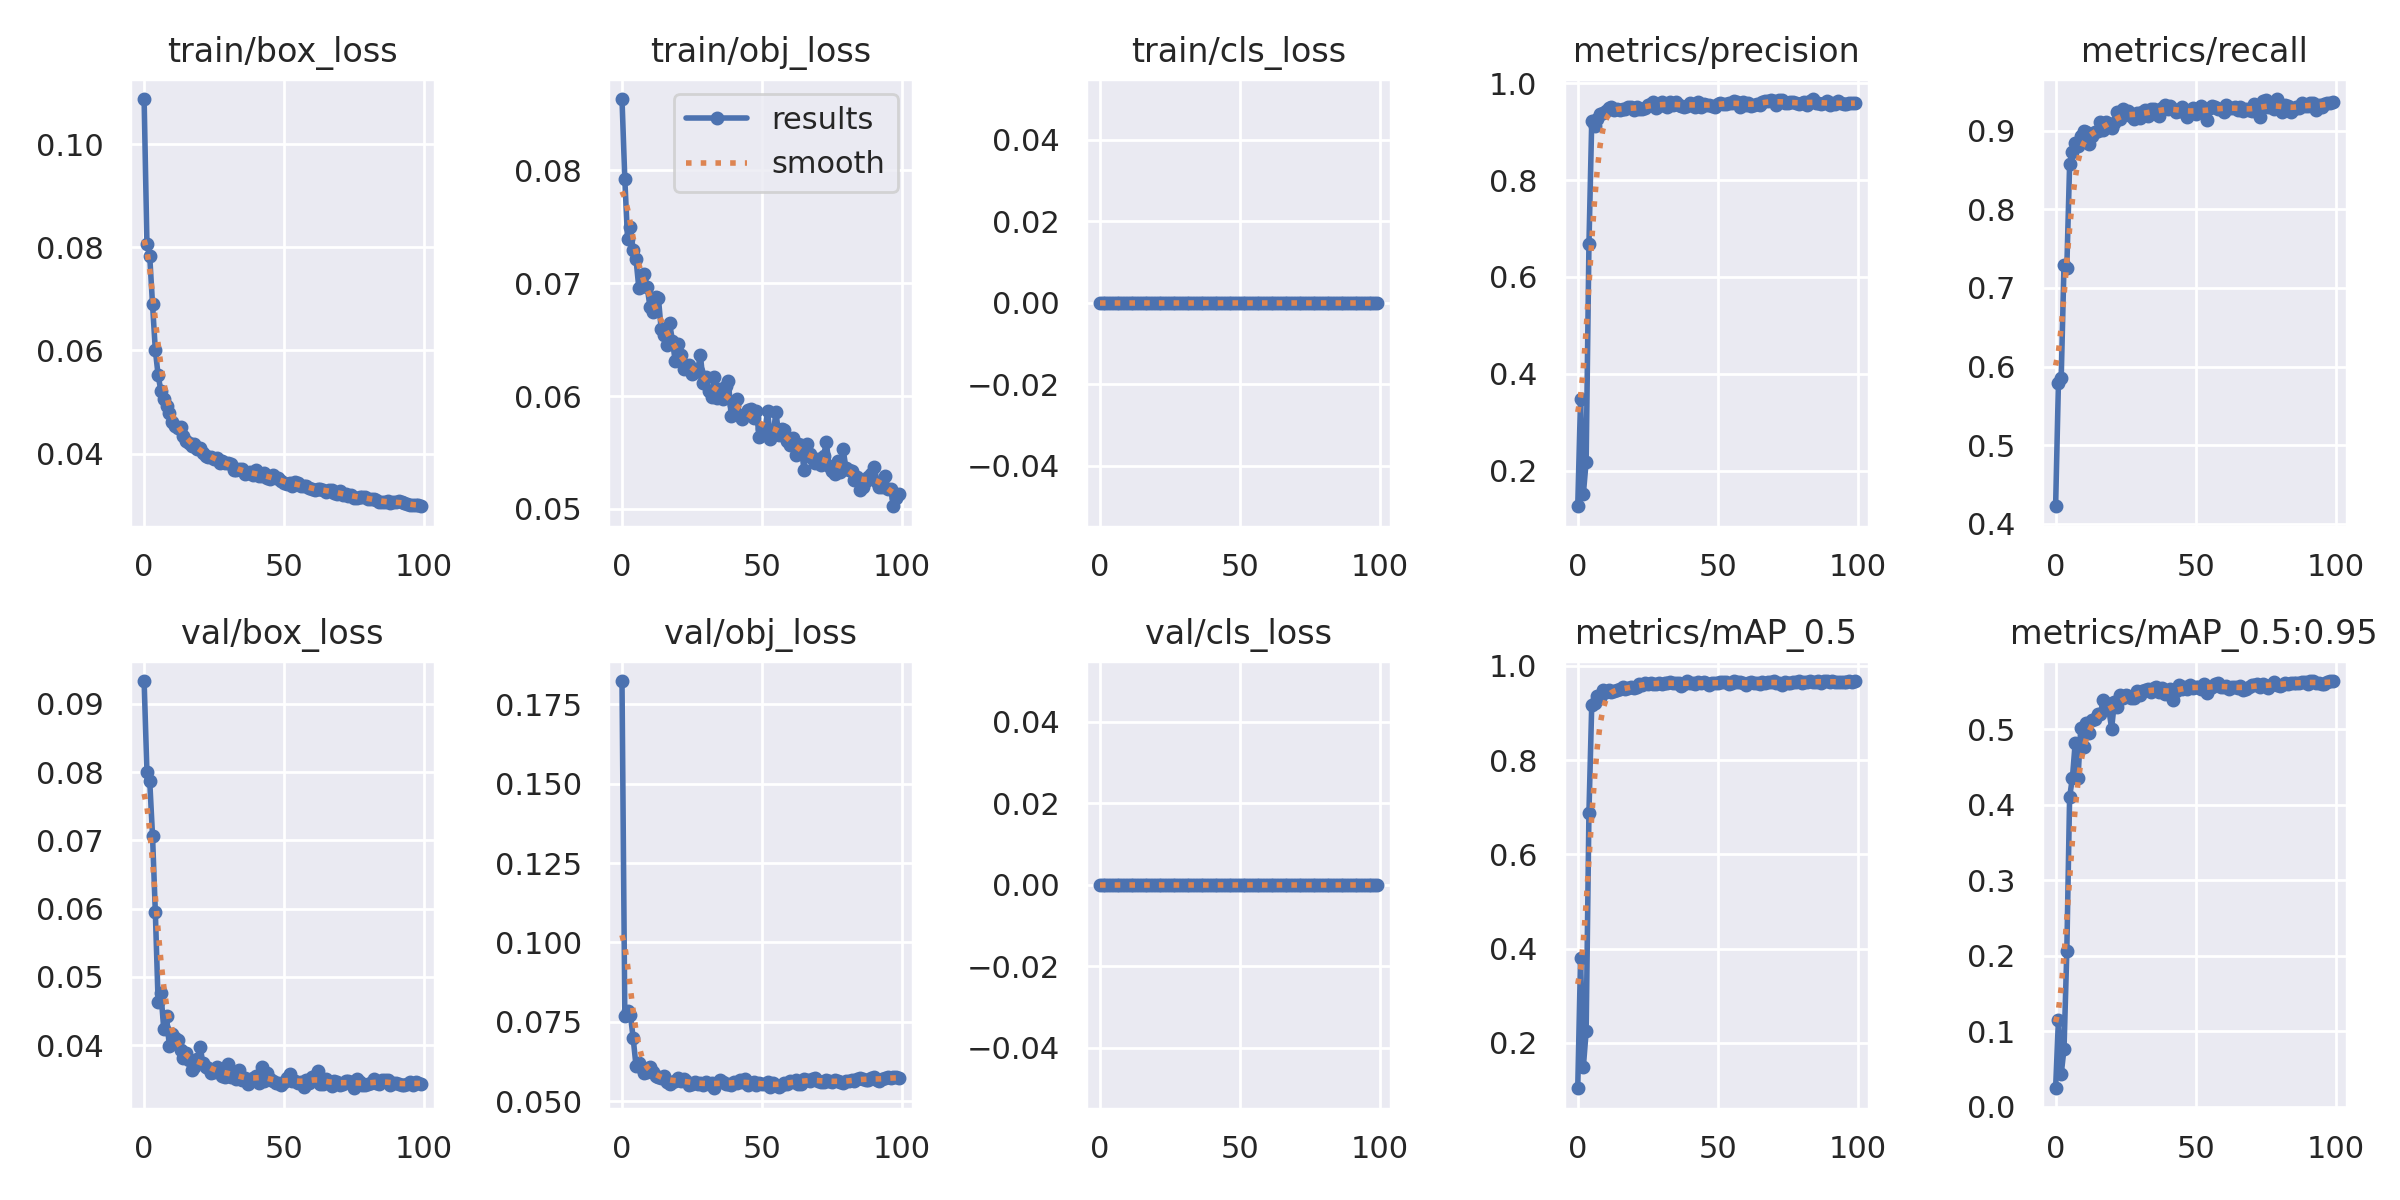


--- 最後一輪訓練的效能參數 ---
訓練輪數 (Epoch): 99
精確率 (Precision): 0.9596
召回率 (Recall): 0.9364
mAP_0.5 (mean Average Precision @ 0.5 IoU): 0.9670
mAP_0.5:0.95 (mean Average Precision @ 0.5-0.95 IoU): 0.5641

訓練好的權重檔儲存在 'runs/train/custom_training_run/weights/best.pt'


In [ ]:
import pandas as pd
from IPython.display import Image, display

# 訓練結果儲存的路徑
results_path = 'runs/train/custom_training_run'

# 1. 顯示訓練過程圖表 (包含 mAP, loss 等)
print("--- 訓練過程圖表 ---")
display(Image(filename=f'{results_path}/results.png', width=1000))

# 2. 讀取訓練日誌並輸出最後一輪的參數
print("\n--- 最後一輪訓練的效能參數 ---")
results_csv_path = f'{results_path}/results.csv'

if os.path.exists(results_csv_path):
    # Pandas 會自動清理欄位名稱前後的空白
    df = pd.read_csv(results_csv_path)
    df.columns = df.columns.str.strip() # 清理欄位名稱的空白字元

    # 取得最後一筆 (也就是最後一輪) 的數據
    last_epoch_stats = df.iloc[-1]

    print(f"訓練輪數 (Epoch): {int(last_epoch_stats['epoch'])}")
    print(f"精確率 (Precision): {last_epoch_stats['metrics/precision']:.4f}")
    print(f"召回率 (Recall): {last_epoch_stats['metrics/recall']:.4f}")
    print(f"mAP_0.5 (mean Average Precision @ 0.5 IoU): {last_epoch_stats['metrics/mAP_0.5']:.4f}")
    print(f"mAP_0.5:0.95 (mean Average Precision @ 0.5-0.95 IoU): {last_epoch_stats['metrics/mAP_0.5:0.95']:.4f}")
    print(f"\n訓練好的權重檔儲存在 '{results_path}/weights/best.pt'")
else:
    print(f"錯誤：找不到訓練日誌檔案 '{results_csv_path}'")

已處理 100/100 張圖片...
預覽: frame_0409.jpg


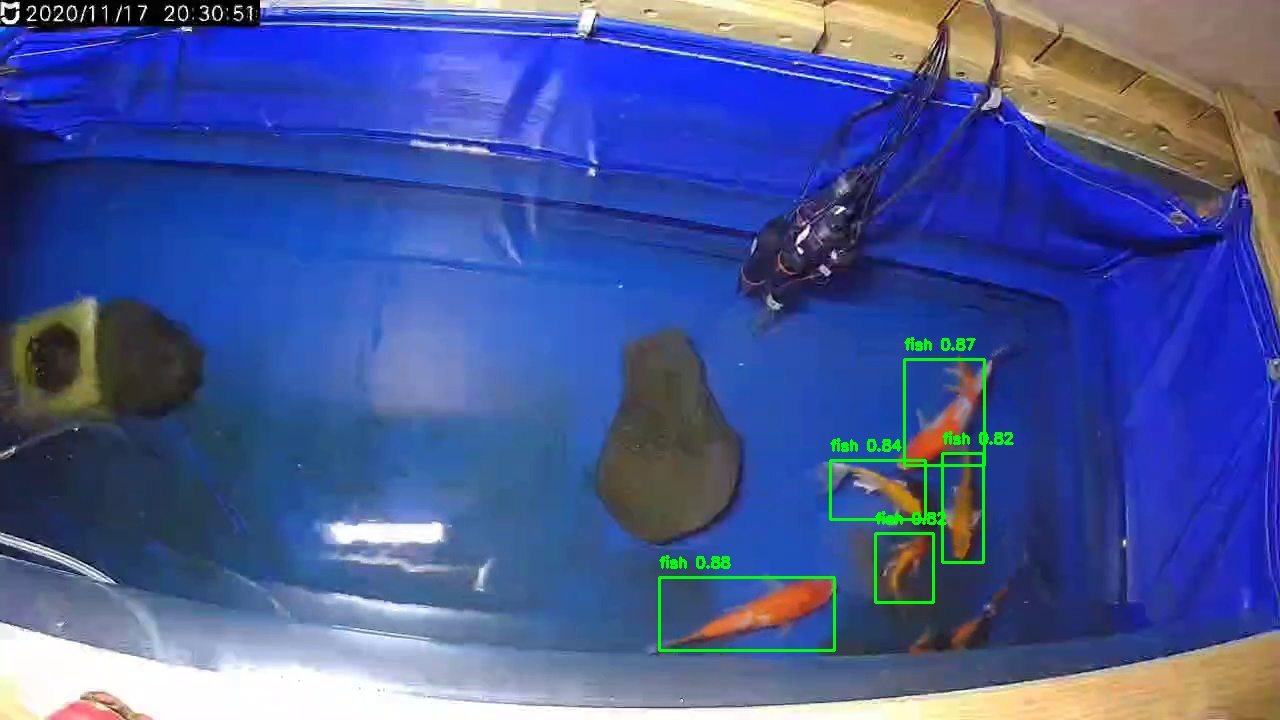


所有偵測和視覺化已完成！
偵測結果已儲存至 '/content/drive/MyDrive/Final_Project/dataset/overlap_test/overlap_Yolov5_output_image.txt'
帶有偵測框的圖片已儲存至 '/content/drive/MyDrive/Final_Project/dataset/overlap_test/overlap_yolov5_output_image'

--- 輸出 TXT 檔案預覽 (前20行) ---
Image: frame_0000.jpg
fish 0.88 171 235 88 181
fish 0.87 244 454 191 111
fish 0.84 847 604 125 55
fish 0.79 761 499 75 60
fish 0.78 419 260 166 65
fish 0.63 745 407 53 84
fish 0.41 211 200 184 66
Image: frame_0001.jpg
fish 0.88 165 253 85 173
fish 0.87 244 454 181 113
fish 0.84 847 601 125 58
fish 0.81 415 261 169 67
fish 0.80 761 499 74 61
fish 0.63 202 200 157 64
fish 0.54 746 404 50 84
Image: frame_0002.jpg
fish 0.87 162 264 86 171
fish 0.86 242 453 177 117
fish 0.84 845 599 126 58


In [ ]:
import torch
import os
import glob
import cv2 # 導入 OpenCV
import numpy as np # 導入 numpy
from IPython.display import display, Image, clear_output

# ==============================================================================
# === 請在這裡修改您的設定 ===
# ==============================================================================

# 1. 模型權重檔案的路徑
MODEL_PATH = '/content/drive/MyDrive/Final_Project/dataset/YoloV5/yolov5_project/yolov5/runs/train/custom_training_run/weights/best.pt'

# 2. 要進行偵測的圖片資料夾路徑
IMAGE_FOLDER_PATH = '/content/drive/MyDrive/Final_Project/dataset/overlap_test/overlap_img' # 範例路徑

# 3. 輸出的偵測結果 .txt 檔案路徑
OUTPUT_TXT_PATH = '/content/drive/MyDrive/Final_Project/dataset/overlap_test/overlap_Yolov5_output_image.txt'

# 4. 儲存視覺化後圖片的資料夾路徑
#    !! 如果此資料夾不存在，程式會自動建立 !!
OUTPUT_IMAGES_FOLDER = '/content/drive/MyDrive/Final_Project/dataset/overlap_test/overlap_yolov5_output_image'

# 5. 信賴度閾值：只儲存和繪製信賴度高於此值的偵測結果
CONFIDENCE_THRESHOLD = 0.4 # 您可以依需求調整 (0.0 ~ 1.0)

# ==============================================================================

# --- 以下為自動化偵測與視覺化腳本，無需修改 ---

try:
    # 載入您自訂訓練的模型
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=MODEL_PATH, force_reload=True)

    # 設定信賴度閾值
    model.conf = CONFIDENCE_THRESHOLD

    print("模型載入成功！")
    print(f"類別名稱: {model.names}")

    # 確保輸出圖片資料夾存在
    if not os.path.exists(OUTPUT_IMAGES_FOLDER):
        os.makedirs(OUTPUT_IMAGES_FOLDER)
        print(f"已建立輸出圖片資料夾: {OUTPUT_IMAGES_FOLDER}")

    # 尋找所有支援的圖片格式
    image_files = []
    supported_formats = ['*.jpg', '*.jpeg', '*.png']
    for fmt in supported_formats:
        image_files.extend(glob.glob(os.path.join(IMAGE_FOLDER_PATH, fmt)))

    # 依檔名排序，確保輸出順序一致
    image_files.sort()

    print(f"\n在 '{IMAGE_FOLDER_PATH}' 中找到 {len(image_files)} 張圖片，開始進行偵測和視覺化...")

    # 開啟檔案準備寫入結果
    with open(OUTPUT_TXT_PATH, 'w', encoding='utf-8') as f:
        for i, image_path in enumerate(image_files):
            # 取得檔名
            filename = os.path.basename(image_path)

            # 寫入圖片標頭到 TXT 檔
            f.write(f"Image: {filename}\n")

            # 執行偵測
            results = model(image_path)

            # 取得原始圖片，用於繪圖
            img_bgr = cv2.imread(image_path)
            if img_bgr is None:
                print(f"警告：無法載入圖片 '{image_path}'，跳過。")
                continue

            # 取得正規化後的 xyxy 格式結果 (x1, y1, x2, y2, confidence, class_id)
            # 這裡我們用 results.pandas().xyxy[0] 比較方便，直接就是像素座標
            predictions_df = results.pandas().xyxy[0]

            # 篩選掉低於閾值的偵測
            predictions_df = predictions_df[predictions_df['confidence'] >= CONFIDENCE_THRESHOLD]

            for _, row in predictions_df.iterrows():
                x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
                conf = row['confidence']
                cls_id = int(row['class'])
                cls_name = row['name'] # 類別名稱

                # 繪製邊界框
                color = (0, 255, 0) # 綠色框
                thickness = 2
                cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color, thickness)

                # 繪製文字 (類別名稱和信賴度)
                label = f"{cls_name} {conf:.2f}"
                cv2.putText(img_bgr, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

                # --- ⭐️⭐️⭐️ 已修改的部分 ⭐️⭐️⭐️ ---
                # 為了與 YOLOv4/v8 格式統一，我們需要輸出 x_min, y_min, width, height
                width = x2 - x1
                height = y2 - y1

                # 直接使用左上角座標 (x1, y1) 而不是中心點座標
                output_line = (f"{cls_name} {conf:.2f} "
                               f"{x1} {y1} " # <-- 修改點：從中心點改成左上角 x, y
                               f"{width} {height}\n")
                f.write(output_line)
                # --- ⭐️⭐️⭐️ 修改結束 ⭐️⭐️⭐️ ---

            # 儲存帶有偵測框的圖片
            output_image_path = os.path.join(OUTPUT_IMAGES_FOLDER, filename)
            cv2.imwrite(output_image_path, img_bgr)

            # (可選) 每處理10張圖片顯示進度
            if (i + 1) % 10 == 0:
                clear_output(wait=True)
                print(f"已處理 {i + 1}/{len(image_files)} 張圖片...")
                # 顯示一張範例圖片
                print(f"預覽: {filename}")
                display(Image(filename=output_image_path, width=400))


    print(f"\n所有偵測和視覺化已完成！")
    print(f"偵測結果已儲存至 '{OUTPUT_TXT_PATH}'")
    print(f"帶有偵測框的圖片已儲存至 '{OUTPUT_IMAGES_FOLDER}'")

    # (可選) 最終預覽輸出的 txt 檔案前20行
    print("\n--- 輸出 TXT 檔案預覽 (前20行) ---")
    # 使用 Python 讀取並印出，避免 !head 在某些環境無法使用
    with open(OUTPUT_TXT_PATH, 'r', encoding='utf-8') as f_preview:
        for i, line in enumerate(f_preview):
            if i >= 20:
                break
            print(line.strip())

except Exception as e:
    print(f"發生錯誤：{e}")
    print("請檢查：")
    print(f"1. 模型路徑 '{MODEL_PATH}' 是否正確。")
    print(f"2. 圖片資料夾路徑 '{IMAGE_FOLDER_PATH}' 是否存在且內含圖片。")
    print(f"3. 輸出圖片資料夾 '{OUTPUT_IMAGES_FOLDER}' 是否有寫入權限。")
    print("4. OpenCV 和其他函式庫是否安裝完整 (`!pip install opencv-python matplotlib pandas`)。")